# Single Cell Biology 
## Mini project : RNA-seq of fly ovaries dataset 

### Gianna Biino, Marianne Scoglio, Gabrielle Blouvac

### Imports 

In [136]:
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

### Snapshot analysis of the Fly Cell Atlas
#### The Ovaries
This project analyses the dataset of the fly cell atlas, containing the single cell transcriptome of the fly's ovaries.
The goal of this project is to research the cell-types and marker genes found in the ovaries.
The data used has already been preprocessed so we will focus on the downstream analysis.

### 0) Data loading 

In [137]:
data = pd.read_csv('ovary.tsv', sep="\t", index_col=0)
adata = ad.AnnData(data.T)
adata.var_names = data.index  # Gene names
adata.obs_names = data.columns  # Cell names
adata

AnnData object with n_obs × n_vars = 7549 × 11943

##### QC and filtering
In order to analyse the data we perform some quality control and filtering first in order to remove poor quality data.

### 1) Preprocessing 

In [138]:
sc.settings.seed=2

normalizing counts per cell
    finished (0:00:00)


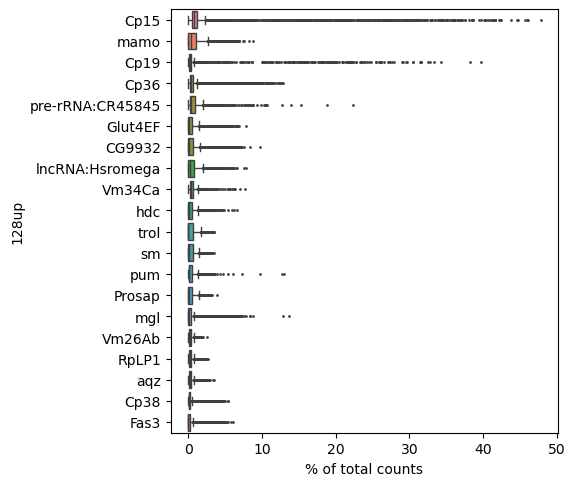

In [139]:
# look at the highest expressed genes
sc.pl.highest_expr_genes(adata, n_top=20)

#### Filtering the cells 

filtered out 726 genes that are detected in less than 3 cells


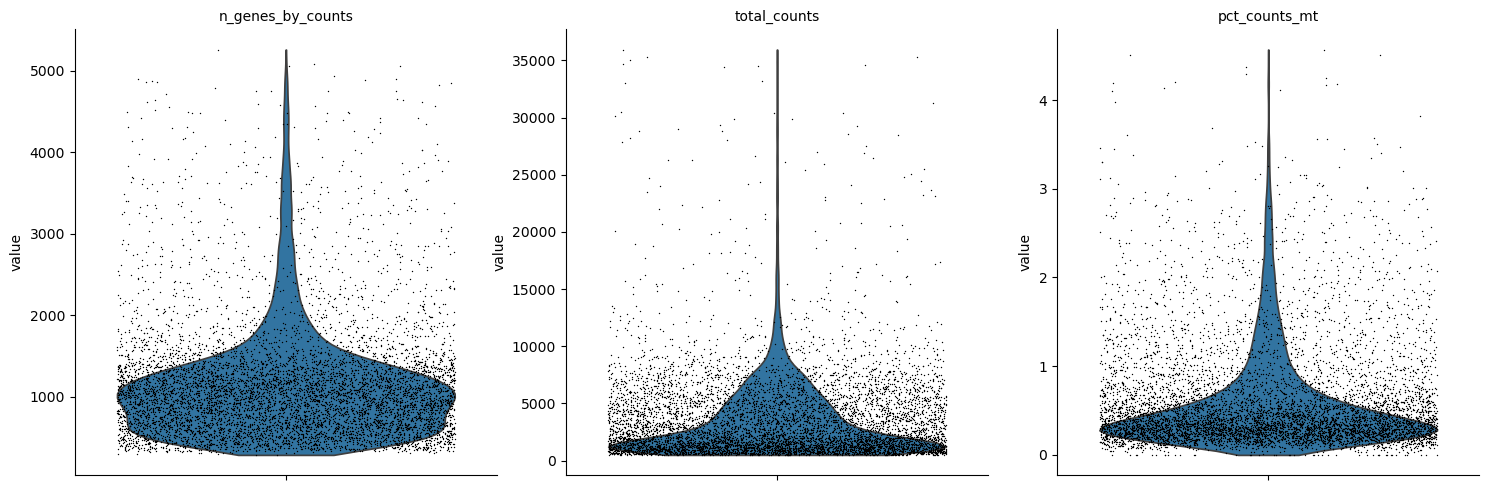

In [140]:
#filter out cells with low gene count and genes that are detected in 3 or less cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# annotate the group of mitochondrial genes as "mt" 
adata.var["mt"] = adata.var_names.str.startswith("mt:")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

# Violin plot to look at the number of genes and cells
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

We observe few cells with a high mitochondrial gene counts, which is great as this means most of the cells are alive and we don't have a lot of dead cells in the sample.

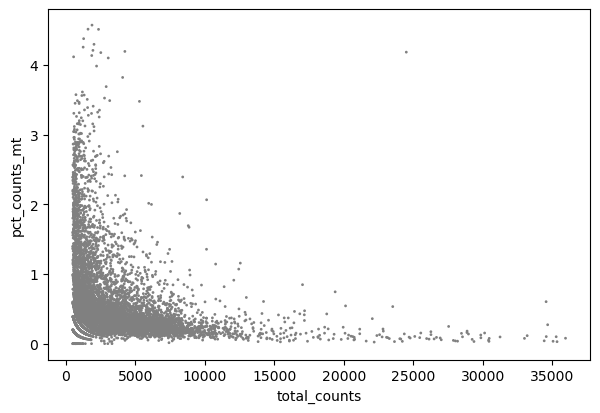

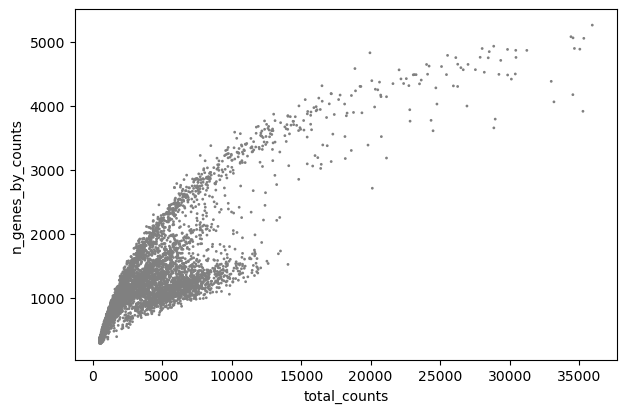

In [141]:
#scatter plots
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

We see that the numbers of mitochondrial genes for each count are below 5 which is quite low, indicating that the cells detected should be healthy. 
We also see that most cells contain a few thousand genes, and there are only some cells that pass over 30'000 genes.
For now we keep the filtering to a minimum and might come back to it

#### Normalization 
In order to be able to compare the gene counts we normalize the data and regress out the effect of the counts per cell and percentage of mitochondrial genes expressed.

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)


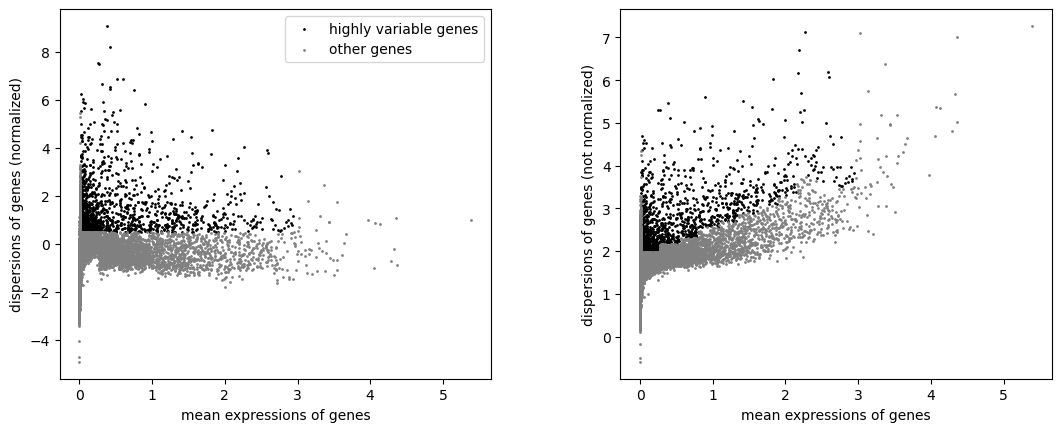

In [142]:
#normalize the total count so that the counts become comparable among cells
sc.pp.normalize_total(adata, target_sum=1e4)
# take the log of the data
sc.pp.log1p(adata)

#look at the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [143]:
#Set the normalized and logarithmized gene expr for later use to .raw
adata.raw = adata.copy()

#filter 
adata = adata[:, adata.var.highly_variable]
#regress out effects of total count per cell
sc.pp.regress_out(adata, ["total_counts"])
#scale the values
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts']


c:\Users\blouv\anaconda3\envs\scanpy_env\lib\site-packages\scanpy\preprocessing\_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:07)


We do not regress out the mitochondrial genes as stated above 

### 2 ) Principal Component Analysis
We run a PCA on the data in order to analyse the variation in the data

In [144]:
#compute the PCA
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:01)


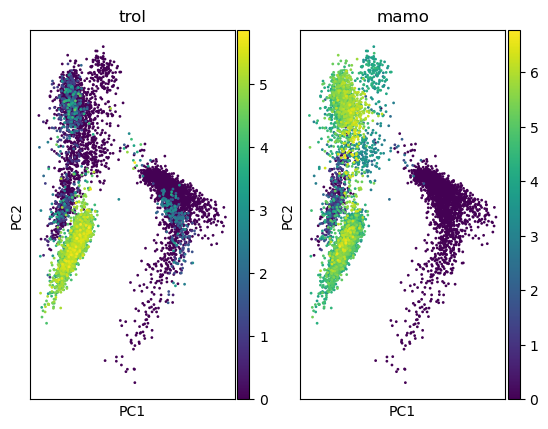

In [145]:
# plot the PCA for the gene Cp15 and mamo
fig, axes = plt.subplots(1,2)
sc.pl.pca(adata, color="trol", ax=axes[0], show=False)
sc.pl.pca(adata, color="mamo", ax=axes[1], show=False)
plt.show()

We see that there is not a big difference of the expression of Cp15 between cells. Mamo however is highly expressed in some cells while not expressed in others.
These two plots only consider the first two principal components though. We have to inspect the contributions of each PC in order to consider as much of the variance as possible.

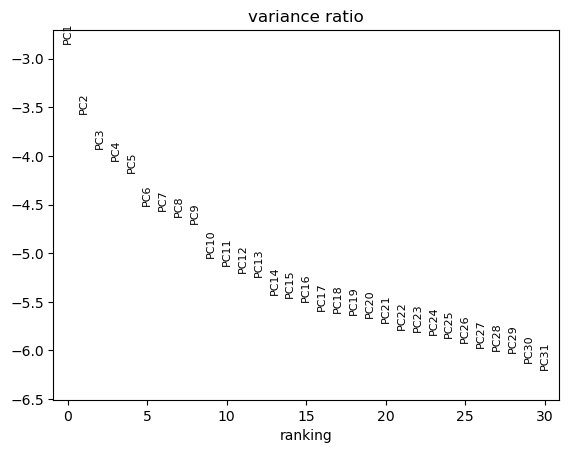

In [146]:
sc.pl.pca_variance_ratio(adata, log=True)

#### Computing neighborhood graph 
using PCA representation

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=25)

computing neighbors
    using 'X_pca' with n_pcs = 14
    finished (0:00:00)


explain we kept 25 
same result ish with 14 but can see clusters better 

In [148]:
sc.tl.leiden(
    adata,
    resolution=0.7,
    #random_state=0,
    #flavor="igraph",
    #n_iterations=2,
    #directed=False,
)

running Leiden clustering
    finished (0:00:00)


### 3) Looking at the data : UMAPs & TSNEs

In [149]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished (0:00:00)
computing UMAP
    finished (0:00:05)


In [150]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:05)


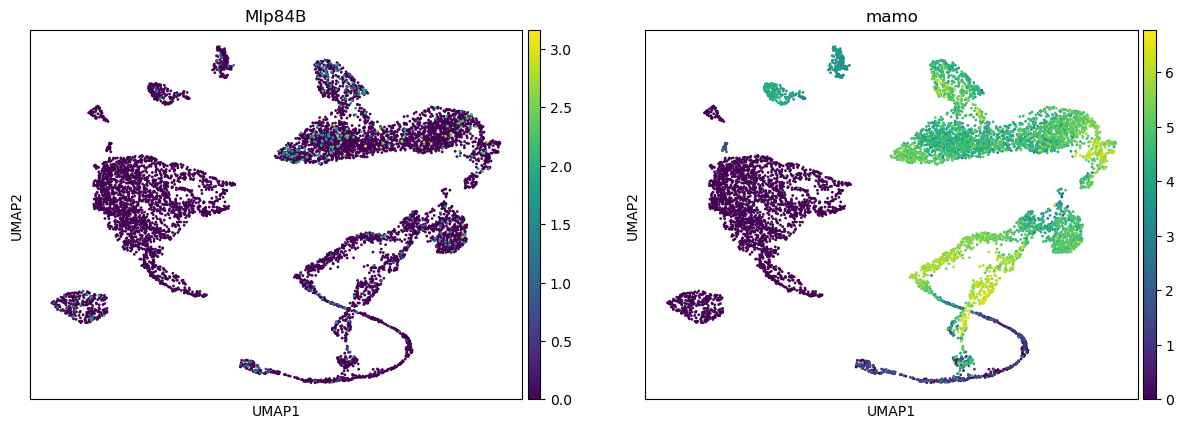

In [151]:
sc.pl.umap(adata, color=["Mlp84B", "mamo"])

first umap blablba top gene = bad 

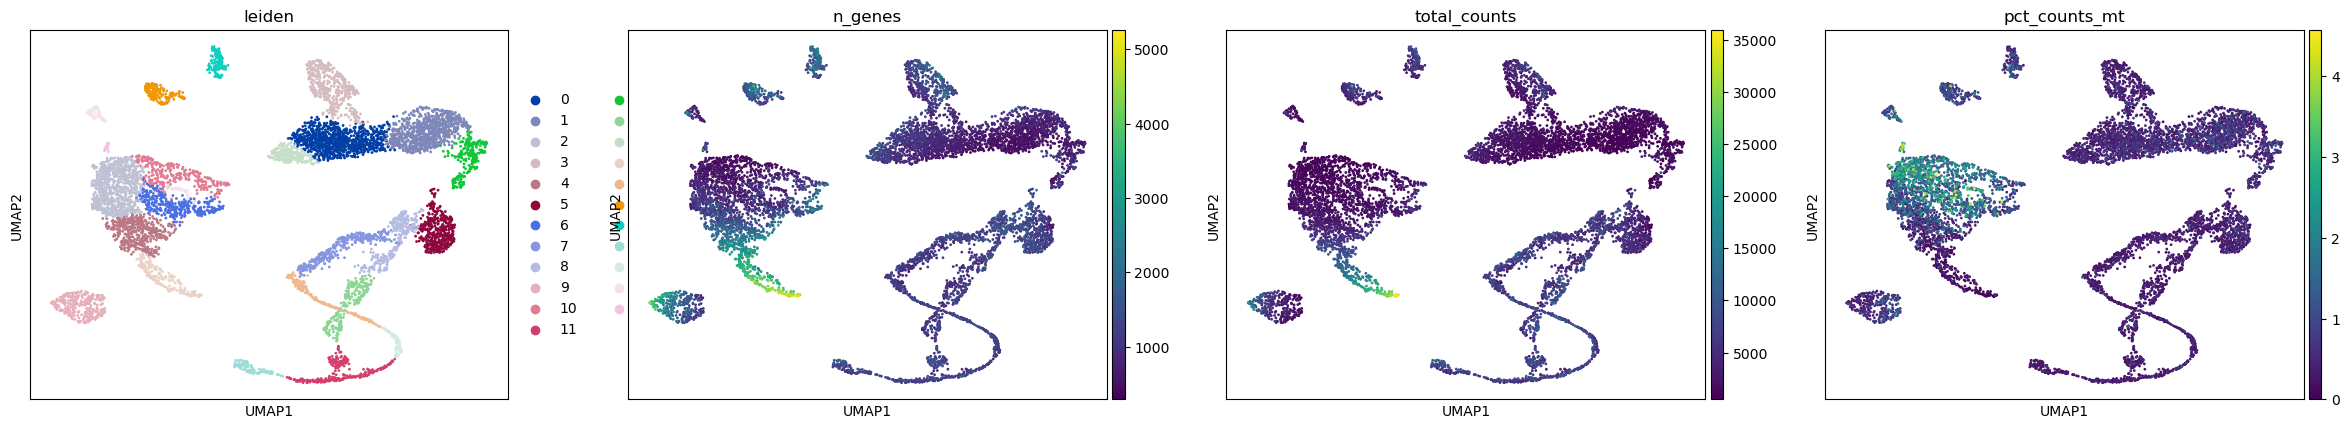

In [152]:
sc.pl.umap(adata, color=["leiden", "n_genes", "total_counts", "pct_counts_mt"])

### to determine : # pcs & neighbour

- observing clusters seems ok compared to Asap
- 1 cluster with high number of genes 
    - is it artefact or true cluster ? could be due to cell size or very active cells (germ cells) ? 
        - if technical = filter again to remove with max number of genes 
- not much mt = cells are alive 



reproductive cycle of the fly = very active ? could explain this 

### 4) Finding marker genes 

try with other distributions 

once we have found the markers genes for each group can do violin plots 

ranking genes
    finished (0:00:07)


c:\Users\blouv\anaconda3\envs\scanpy_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\blouv\anaconda3\envs\scanpy_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\blouv\anaconda3\envs\scanpy_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:440: PerformanceWarning: Da

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


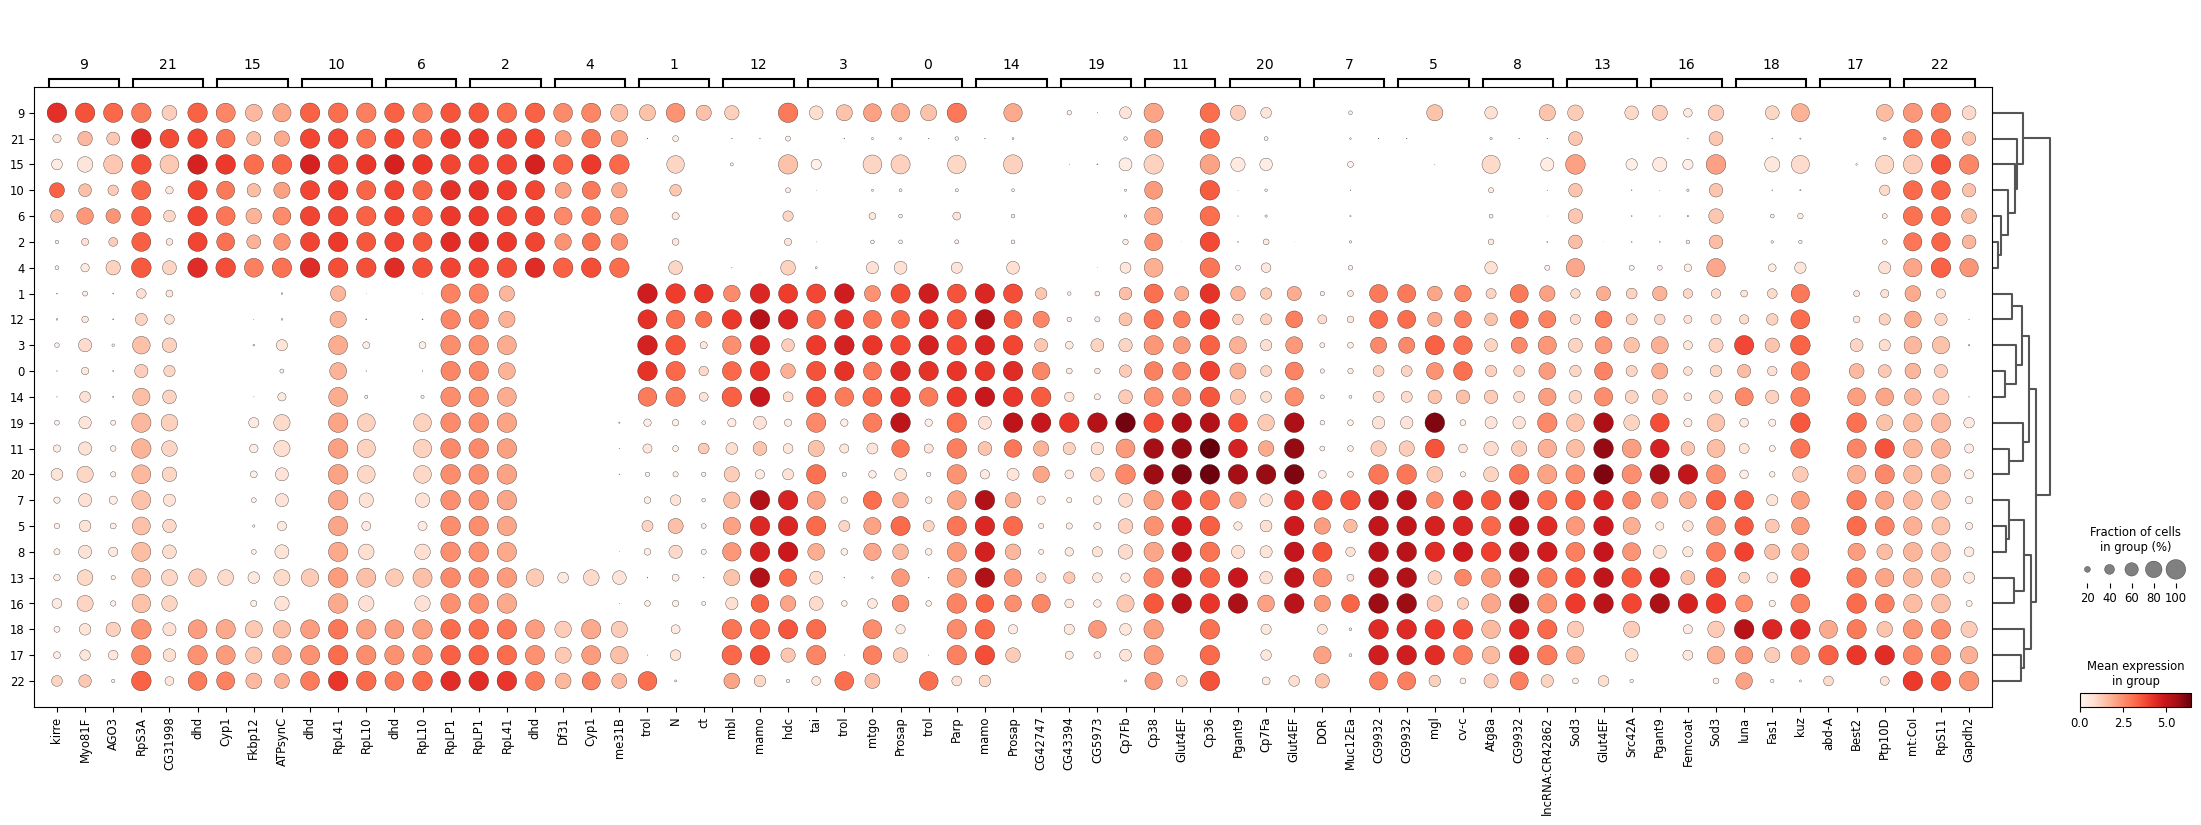

In [157]:
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',          # Cluster labels (e.g., 'leiden' or 'louvain')
    method='t-test',         # Default: Wilcoxon rank-sum test
    key_added='rank_genes_groups'     # Key to store results in adata.uns
)
# Get top 5 markers per cluster
markers = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes_groups')
top_markers = markers[markers.pvals_adj < 0.05].groupby('group').head(5)

sc.pl.rank_genes_groups_dotplot(adata, groupby='leiden', n_genes=3)
#sc.pl.rank_genes_groups_heatmap(adata, groupby='leiden', n_genes=5)

plots qu'on pourrait faire : 
pour les bons groupes (oviduct) = violin plots des markers genes + coloration cluster umap 
pour les stage germline = texte pourquoi on a pas un bon marker 
+ choisir genre 4 marker pour tout les stages de 5 à 8 = on dit 1 cluster
--> coloration du biiig cluster umap 


c:\Users\blouv\anaconda3\envs\scanpy_env\lib\site-packages\scanpy\plotting\_tools\__init__.py:1320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


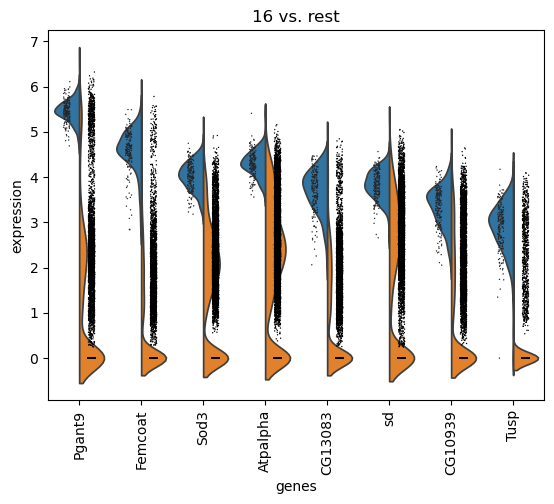

In [161]:
sc.pl.rank_genes_groups_violin(adata, groups="16", n_genes=8)

### 5) Annotations : finding cell types 

use ASAP (manuel)

### add results from asap see excel 


## Conclusion

### image finale regroupe les clusters differents see whatsapp